In [1]:
%config InlineBackend.figure_format = 'retina'

In [7]:
from math import pi
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from jax import grad

### Lets generate a waveform

In [3]:
# Get a frequency domain waveform
# source parameters

m1_msun = 20.0 # In solar masses
m2_msun = 19.0
chi1 = 0.5 # Dimensionless spin
chi2 = -0.5
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
polarization_angle = 0.2 # Polarization angle

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

# These are the parametrs that go into the waveform generator
# Note that JAX does not give index errors, so if you pass in the
# the wrong array it will behave strangely
theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])

# Now we need to generate the frequency grid
f_l = 24
f_u = 512
del_f = 0.01
fs = jnp.arange(f_l, f_u, del_f)

# And finally lets generate the waveform!
hp_ripple, hc_ripple = IMRPhenomD.gen_IMRPhenomD_polar(fs, theta_ripple)

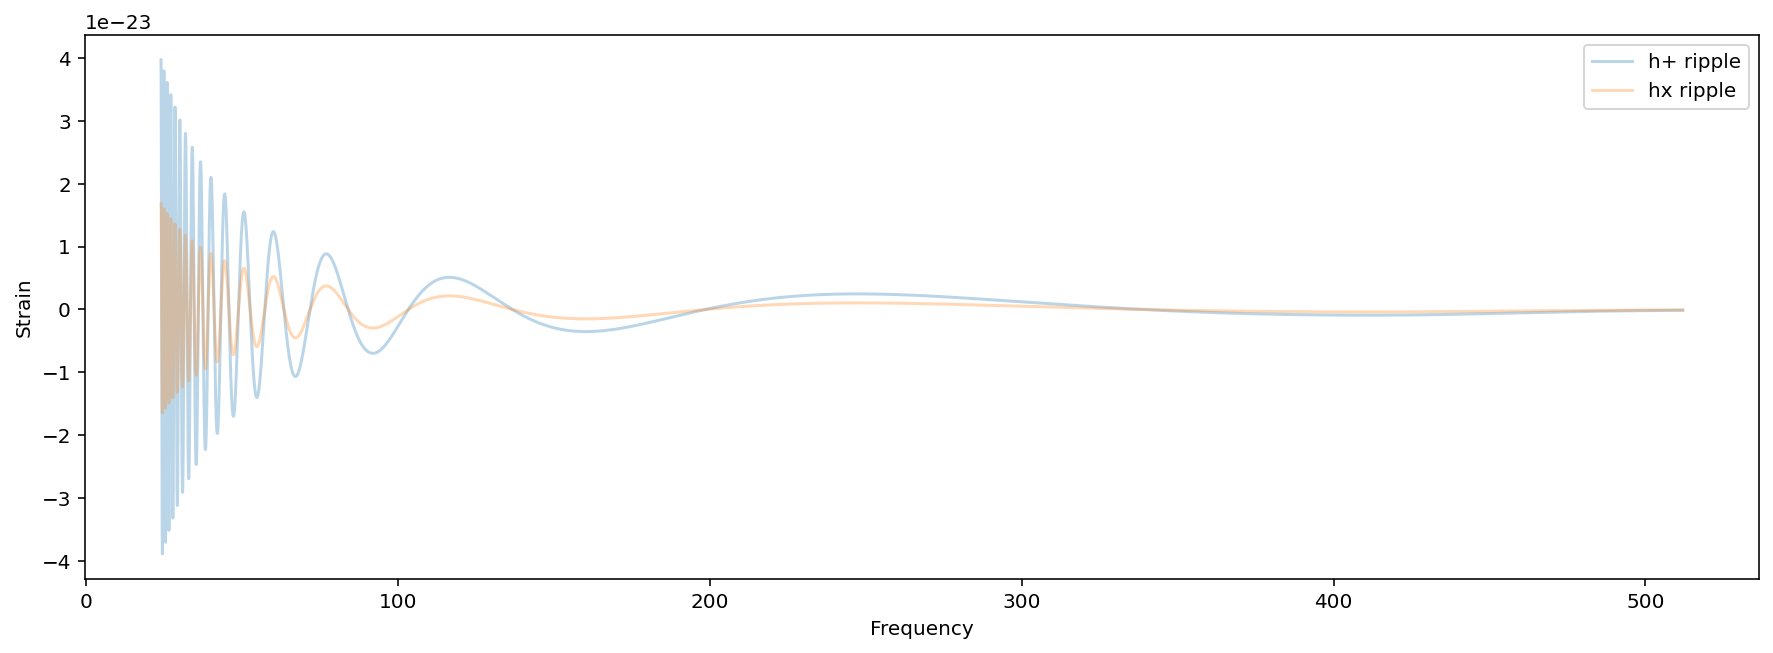

In [4]:
# Now we can plot it
plt.figure(figsize=(15, 5))

plt.plot(fs, hp_ripple.real, label="h+ ripple", alpha=0.3)
plt.plot(fs, hc_ripple.real, label="hx ripple", alpha=0.3)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.show()

### Something more simple?

The h+ and hx polarizations are constructed using a more primitive function which might also be useful to access! Internally, this is referred to as h0 and doesn't include infomation on the inclination angle or polarization angle. This would be similar to having an optimal detector orientation for just one of the polarization states. 

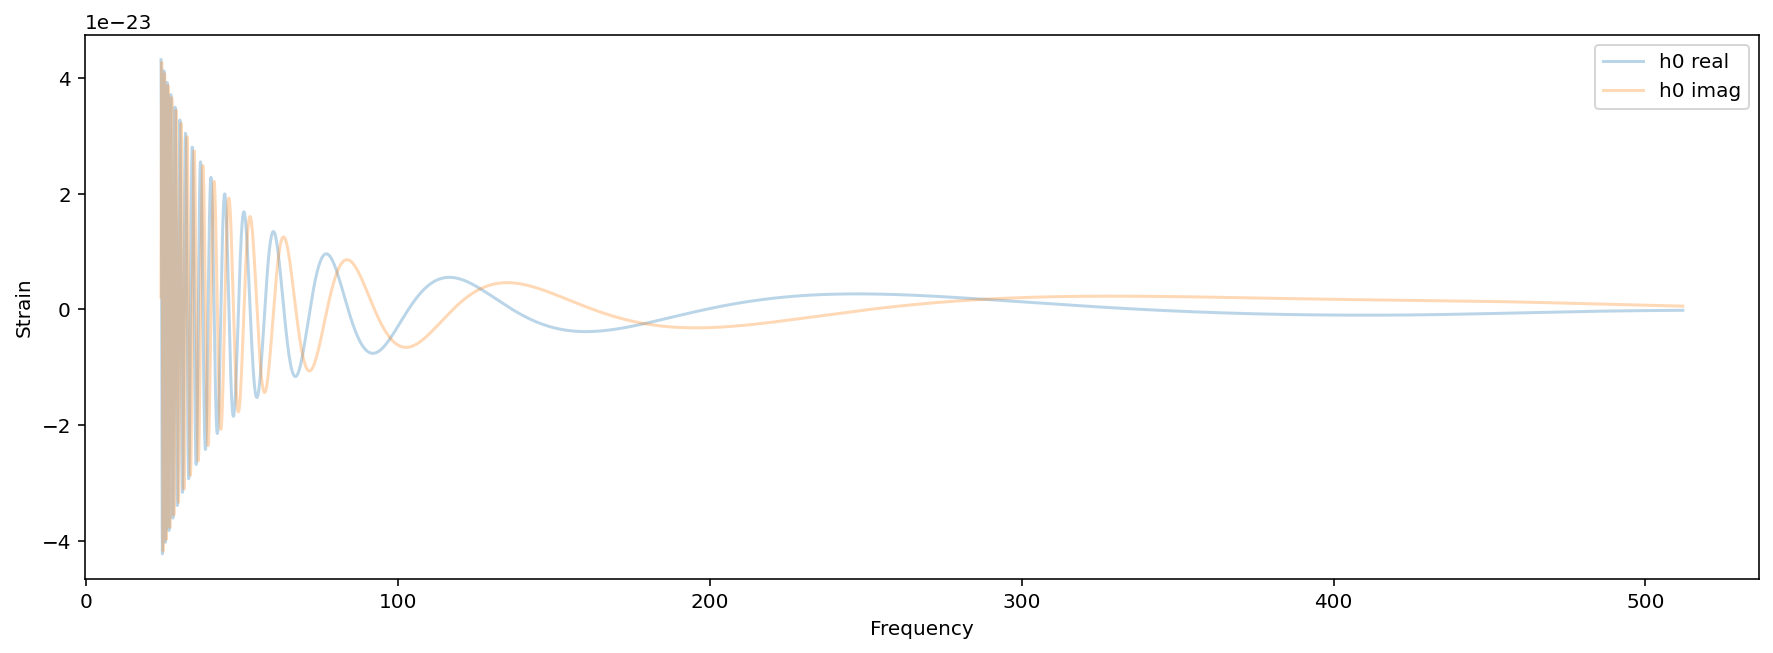

In [11]:
# These are the parametrs that go into the waveform generator. Note that its now shorter than above since we 
# don't need inclination and polarization angles
theta_ripple_h0 = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic])

# And finally lets generate the waveform!
h0_ripple = IMRPhenomD.gen_IMRPhenomD(fs, theta_ripple_h0)

# Now we can plot it
plt.figure(figsize=(15, 5))

plt.plot(fs, h0_ripple.real, label="h0 real", alpha=0.3)
plt.plot(fs, h0_ripple.imag, label="h0 imag", alpha=0.3)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.show()

In [10]:
# Finally, lets take some derivatives!
# We start by writing a simple lambda function to make something that only depends
# on the intrinsic parameters

# Note here that JAX is expecting a scalar output to compute derivatives
# We therefore just select a single frequency point to make this easy
# We also take the real part as default jax expects floats as outputs, not complex numbers
h0_simple = lambda theta: IMRPhenomD.gen_IMRPhenomD(fs[0], theta).real

h0_grad = grad(h0_simple)
print(h0_grad(theta_ripple_h0))

[-1.95329088e-23 -1.58178973e-20  1.78204685e-22  1.68027333e-22
 -9.80152369e-26  3.23552533e-22 -2.14562437e-24]
